# Timeseries Sentinel 2 from openEO
In this Notebook, we will extract time series of Sentinel-2 NDVI from a Data Cube for molinia mapping

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import scipy.signal
import shapely.geometry
import sys
import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas
import contextily as cx
#import c as cx
import seaborn as sns
from datetime import datetime

%matplotlib inline

## Loading the geojson with the fields

In [2]:
with open("fieldwork_re.geojson") as f:
    features = json.load(f)["features"]
    fields = shapely.geometry.GeometryCollection([shapely.geometry.shape(ftr["geometry"]) for ftr in features])
    attributes = shapely.geometry.GeometryCollection([shapely.geometry.shape(ftr["geometry"]) for ftr in features])
fields
fields.bounds

(4.401145730661842, 50.92621288097645, 5.691231924386651, 51.49023488842182)

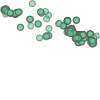

In [3]:
fields

In [31]:
start_date = "2021-04-01"
end_date = "2023-11-30"
bands = [ "B04", "B08", "B11", "SCL"]

In [32]:
con  = openeo.connect("https://openeo.vito.be").authenticate_oidc(provider_id="egi")
bbox = {"west": fields.bounds[0] , "south":fields.bounds[1] , "east": fields.bounds[2], "north": fields.bounds[3], "crs": "EPSG:4326"}
dates = (start_date, end_date)

datacube = con.load_collection("SENTINEL2_L2A", temporal_extent=dates, bands=bands, spatial_extent = bbox)

from openeo.extra.spectral_indices.spectral_indices import compute_indices
indices = compute_indices(datacube, indices=["NDVI", "NDMI"], platform="SENTINEL2")
#datacube2 = datacube.merge_cubes(indices)

Authenticated using refresh token.


## Masking with a kernel

In [33]:
#define the masking kernel
g = scipy.signal.windows.gaussian(11, std=1.5)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

classification = datacube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [34]:
masked_data = indices.mask(mask)
type(masked_data)

openeo.rest.datacube.DataCube

## Make composites
Preferably dekadal composites which is 1-10, 11-20 and 21-end of each month, but also try monthly composites

In [36]:
masked_dek_all = masked_data.aggregate_temporal_period(period = 'dekad', reducer = 'median')

In [37]:
masked_dek_all

In [38]:
masked_mon_all = masked_data.aggregate_temporal_period(period = 'month', reducer = 'median')

In [39]:
masked_mon_all

In [ ]:
masked_mon_int = masked_mon_all.apply_dimension(
    dimension = "t",
    process = "array_interpolate_linear")

#masked_dek = masked_dek_all.filter_spatial(geometries="fields")
masked_mon = masked_dek_int.aggregate_spatial(geometries=fields, reducer="mean")

In [41]:
masked_dek_int = masked_dek_all.apply_dimension(
    dimension = "t",
    process = "array_interpolate_linear")

#masked_dek = masked_dek_all.filter_spatial(geometries="fields")
masked_dek = masked_dek_int.aggregate_spatial(geometries=fields, reducer="mean")

In [42]:
 masked_mon

In [43]:
 masked_dek

## Download the time series

In [44]:
masked_mon.save_result("JSON")
job1 = masked_mon.create_job(title = "plots 2022 Molinia monthly")
job1.start()

<BatchJob job_id='j-231209a580874fb0aab1f8535e19d71c'>

In [46]:
job1.status()

'running'

In [47]:
job1.get_results().download_files("results")

[WindowsPath('results/timeseries.json'),
 WindowsPath('results/job-results.json')]

In [52]:
masked_dek.save_result("JSON")
job2 = masked_dek.create_job(title = "plots 2022 Molinia dekadal")
job2.start()

<BatchJob job_id='j-2312092e35b84dfcaf9c33fed73e206b'>

In [54]:
job2.status()

'finished'

In [55]:
job2.get_results().download_files("results")

[WindowsPath('results/timeseries.json'),
 WindowsPath('results/job-results.json')]